In [151]:
import datetime
import logging
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from tqdm import tqdm
from utils.forecast import get_dwd_forecast

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.forecast import get_dwd_forecast
from studies.utils.dwd_data import DWD_Dataset, Feature

import polars as pl

In [152]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"
DOUBLE_COL_FIG_SIZE = (15, 5)

In [153]:
dataset_model_1 = DWD_Dataset(source_path="../data/dwd", model=1,)
dataset_model_2 = DWD_Dataset(source_path="../data/dwd", model=2,)

First look at one specific station

In [154]:
STATION_ID = 257

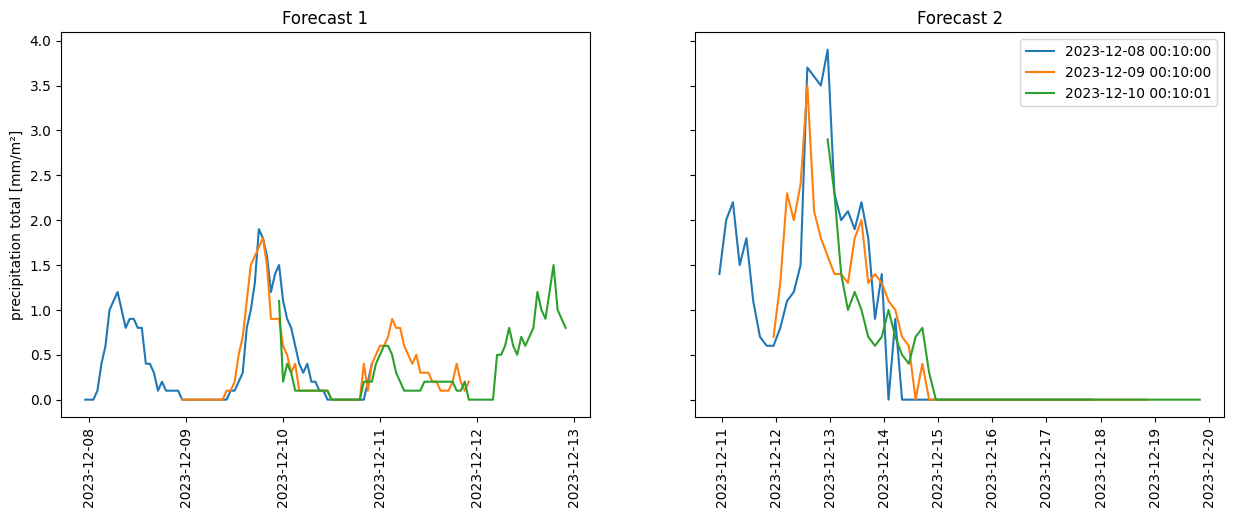

In [155]:
forecast1 = dataset_model_1.get_forecast(station_id=STATION_ID)
forecast2 = dataset_model_2.get_forecast(station_id=STATION_ID)


fig, axs = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)
for call_time in sorted(forecast1["call_time"].unique())[:3]:
    sub_df_forecast = forecast1[forecast1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    axs[0].plot(t, values, label=call_time)
    
    sub_df_forecast = forecast2[forecast2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    axs[1].plot(t, values, label=call_time)

axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Forecast 1")
axs[0].set_ylabel("precipitation total [mm/m²]")
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Forecast 2")
axs[1].legend()

fig.savefig(FIG_SAVE_BASE_PATH + "precipitation_forecast.pdf")

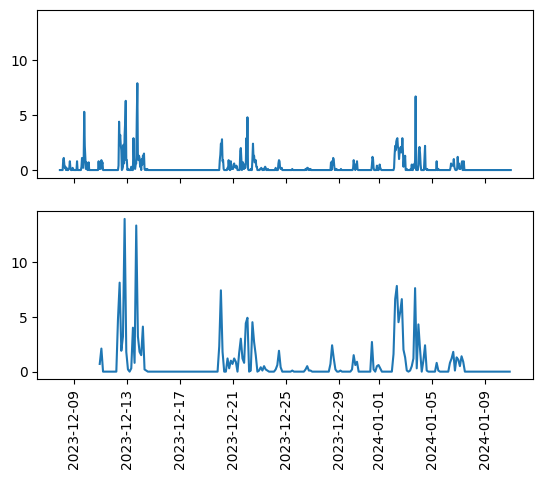

In [156]:


fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
real_data = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[0].plot(real_data["time"], real_data["precipitation_real"])
real_data = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[1].plot(real_data["time"], real_data["precipitation_real"])

axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)


Text(0.5, 0.98, 'Difference: Precipitation Forecast and Historical Precipitation for station: 257')

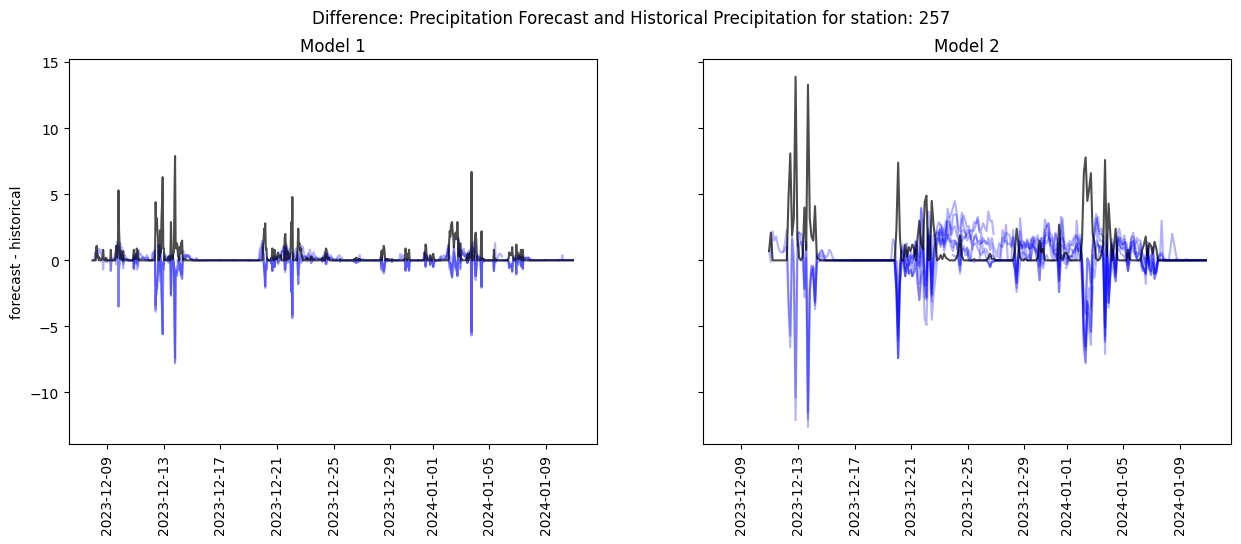

In [157]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
merge1 = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
merge2 = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")

# fig, ax1 = plt.subplots()

api_call_times = sorted(merge1["call_time"].unique())
num_api_calls = len(api_call_times)
for idx, call_time in enumerate(api_call_times):
    sub_df_forecast = merge1[merge1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax1.plot(t, error, c="b", alpha=0.3)
    

    sub_df_forecast = merge2[merge2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax2.plot(t, error, c="b", alpha=0.3)

# plot real amount of rain
ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
    
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax2.set_title("Model 2")
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))


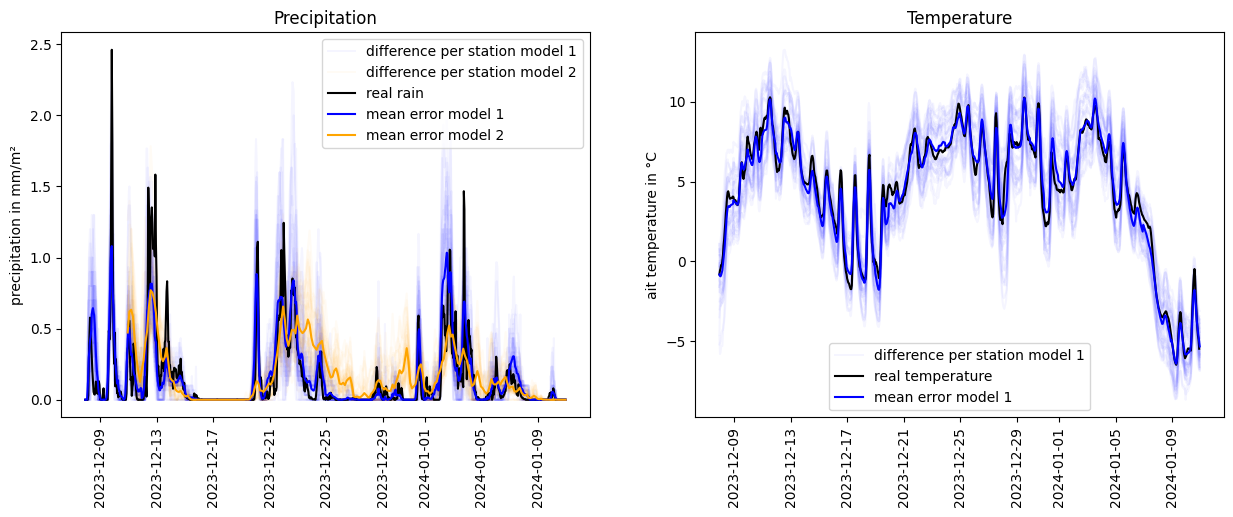

In [158]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE)
merge1 = dataset_model_1.get_merge()
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


individual_groups = merge1.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("station_id").unique()):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(sub_df.index, sub_df["precipitation_forecast"], c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

    ax2.plot(sub_df.index, sub_df["air_temperature_forecast"], c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

individual_groups = merge2.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("station_id").unique()):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(sub_df.index, sub_df["precipitation_forecast"] / 3, c="orange", alpha=0.04, label="difference per station model 2" if not idx else "")
    


time_group = merge1.groupby(["time"]).mean()
ax1.plot(time_group.index, time_group["precipitation_real"], c="k", label="real rain")
ax1.plot(time_group.index, time_group["precipitation_forecast"], c="b", label="mean error model 1")


time_group = merge2.groupby(["time"]).mean()
ax1.plot(time_group.index, time_group["precipitation_forecast"]/ 3, c="orange", label="mean error model 2")

time_group = merge1.groupby(["time"]).mean()
ax2.plot(time_group.index, time_group["air_temperature_real"], c="k", label="real temperature")
ax2.plot(time_group.index, time_group["air_temperature_forecast"], c="b", label="mean error model 1")


# ax1.plot(merge1.index, merge1["precipitation_real"], c="k", label="real_rain")
# 
# 
# ax2.plot(merge2.index, merge2["precipitation_error"], c="b", label="mean error")
# ax2.plot(merge2.index, merge2["precipitation_real"], c="k", label="real_rain")


# 
# api_call_times = sorted(merge1["call_time"].unique())
# num_api_calls = len(api_call_times)
# for idx, call_time in enumerate(api_call_times):
#     sub_df_forecast = merge1[merge1["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax1.plot(t, error, c="b", alpha=0.3)
#     
# 
#     sub_df_forecast = merge2[merge2["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax2.plot(t, error, c="b", alpha=0.3)
# 
# # plot real amount of rain
# ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
# ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
#     
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("precipitation in mm/m²")
ax2.set_ylabel("ait temperature in °C")
ax1.set_title("Precipitation")
ax2.set_title("Temperature")
ax1.legend()
ax2.legend()
# fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))
# 
# # compute correlation


what is the relative error $(forecast - historical) / historical$ 

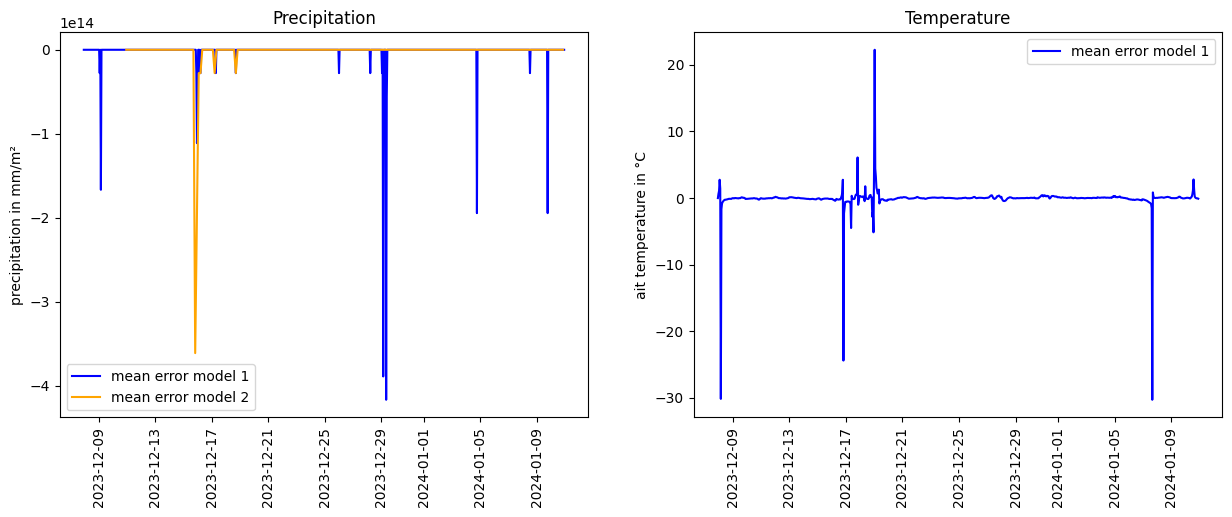

In [159]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE)
merge1 = dataset_model_1.get_merge()
# merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
# merge2["precipitation_error"] = merge2["precipitation_error"].abs()


individual_groups = merge1.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("station_id").unique()):
    sub_df = individual_groups.xs(station_id, level="station_id")
    # ax1.plot(sub_df.index, sub_df["precipitation_error"] / (sub_df["precipitation_real"] + 1e-16), c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

    # ax2.plot(sub_df.index, sub_df["air_temperature_error"], c="blue", alpha=0.04, label="difference per station model 1" if not idx else "")

individual_groups = merge2.groupby(["station_id", "time"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("station_id").unique()):
    sub_df = individual_groups.xs(station_id, level="station_id")
    # ax1.plot(sub_df.index, sub_df["precipitation_error"] / (sub_df["precipitation_real"] + 1e-16), c="orange", alpha=0.04, label="difference per station model 2" if not idx else "")
    


time_group = merge1.groupby(["time"]).mean()
# ax1.plot(time_group.index, time_group["precipitation_real"], c="k", label="real rain")
ax1.plot(time_group.index, time_group["precipitation_error"] / (time_group["precipitation_forecast"] + 1e-16), c="b", label="mean error model 1")


time_group = merge2.groupby(["time"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"]/ (time_group["precipitation_forecast"] + 1e-16), c="orange", label="mean error model 2")

time_group = merge1.groupby(["time"]).mean()
# ax2.plot(time_group.index, time_group["air_temperature_real"], c="k", label="real temperature")
ax2.plot(time_group.index, time_group["air_temperature_error"] / (time_group["air_temperature_real"]), c="b", label="mean error model 1")


# ax1.plot(merge1.index, merge1["precipitation_real"], c="k", label="real_rain")
# 
# 
# ax2.plot(merge2.index, merge2["precipitation_error"], c="b", label="mean error")
# ax2.plot(merge2.index, merge2["precipitation_real"], c="k", label="real_rain")


# 
# api_call_times = sorted(merge1["call_time"].unique())
# num_api_calls = len(api_call_times)
# for idx, call_time in enumerate(api_call_times):
#     sub_df_forecast = merge1[merge1["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax1.plot(t, error, c="b", alpha=0.3)
#     
# 
#     sub_df_forecast = merge2[merge2["call_time"] == call_time]
#     t = sub_df_forecast["time"]
#     error = sub_df_forecast["precipitation_error"]
#     ax2.plot(t, error, c="b", alpha=0.3)
# 
# # plot real amount of rain
# ax1.plot(merge1["time"], merge1["precipitation_real"], c="k", alpha=0.7, label="real rain")
# ax2.plot(merge2["time"], merge2["precipitation_real"], c="k", alpha=0.7, label="real rain")
#     
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("precipitation in mm/m²")
ax2.set_ylabel("ait temperature in °C")
ax1.set_title("Precipitation")
ax2.set_title("Temperature")
ax1.legend()
ax2.legend()
# fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))
# 
# # compute correlation


What is the general trend of the error in  model 1  and model 2

In [160]:
merge1 = dataset_model_1.get_merge()

call_times = sorted(merge1["call_time"].unique())
station_ids = sorted(merge1["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge1[(merge1["call_time"] == call_time) & (merge1["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 72:
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"].values[:72])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_1 = np.stack(result)



In [161]:
merge2 = dataset_model_2.get_merge() 

call_times = sorted(merge2["call_time"].unique())
station_ids = sorted(merge2["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge2[(merge2["call_time"] == call_time) & (merge2["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 56:  # 56 is how many samples are expected in a forecast of model 2
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"][:56])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_2 = np.stack(result)

(25, 36, 56)
coef:  [ 0.19674394 -0.00389985]


Text(0.5, 1.0, 'Model 2')

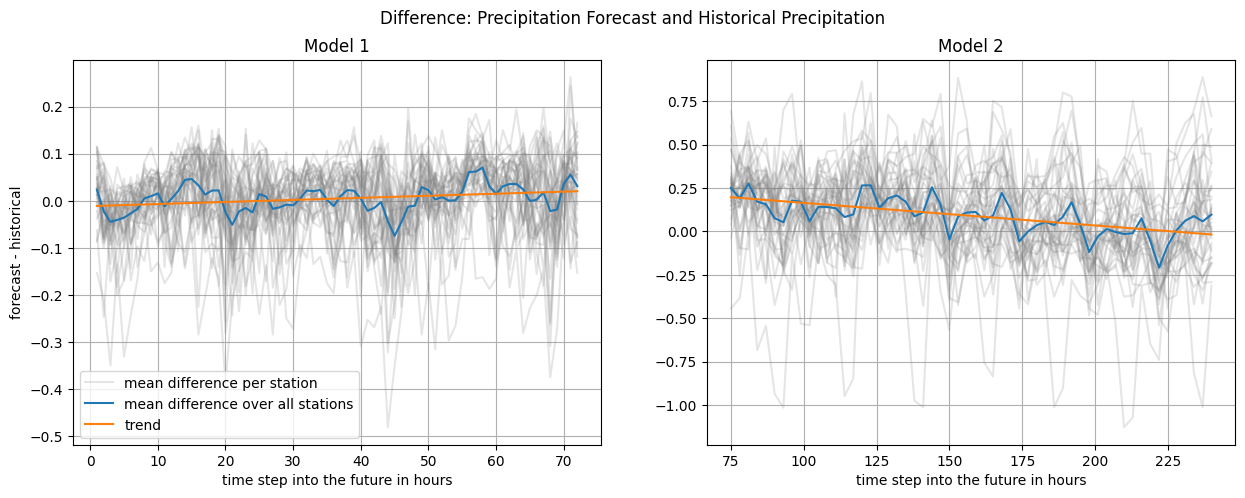

In [162]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# MODEL 1

station_errors = error_mat_model_1.mean(axis=0)
x_axis = np.arange(1, station_errors.shape[-1] + 1)

for idx, station_error in enumerate(station_errors):
    ax1.plot(x_axis, station_error, label="mean difference per station" if idx == 0 else "", color="grey", alpha=0.2)
forecast_error = station_errors.mean(axis=0)
ax1.plot(x_axis, forecast_error, label="mean difference over all stations")

# extract trend
x = np.arange(station_errors.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef

ax1.plot(x_axis, regression, label="trend")

ax1.grid()
ax1.legend()
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax1.set_xlabel("time step into the future in hours")


# MODEL 2
print(error_mat_model_2.shape)
station_errors = error_mat_model_2.mean(axis=0)
x_axis = (np.arange(1, station_errors.shape[-1] + 1) * 3) + 72

for idx, station_error in enumerate(station_errors):
    ax2.plot(x_axis, station_error, label="mean difference per station" if idx == 0 else "", color="grey", alpha=0.2)
forecast_error = station_errors.mean(axis=0)
ax2.plot(x_axis, forecast_error, label="mean difference over all stations")

# extract trend
x = np.arange(station_errors.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef

ax2.plot(x_axis, regression, label="trend")

ax2.grid()
ax2.set_xlabel("time step into the future in hours")
print("coef: ", regression_coef)

ax2.set_title("Model 2")

# TODO: ask if we would use bar plots -> h

get confidence intervalls of the mean curve (blue) with bootstrap

In [163]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000

# MODEL 1

flatten_errors_1 = np.concatenate(error_mat_model_1, axis=0)
N_1 = len(flatten_errors_1)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_1 = np.empty((flatten_errors_1.shape[1], N_BOOT))

for idx, time_step_error in enumerate(tqdm(flatten_errors_1.T, desc="Bootstrap Model 1")):
    simulated_errors = np.random.choice(time_step_error, size=(N_BOOT, N_1), replace=True)
    mean_1 = simulated_errors.mean(axis=1)
    # print(boot_strap_means_1.shape, mean.shape)
    boot_strap_means_1[idx] = simulated_errors.mean(axis=1)
# MODEL 2

flatten_errors_2 = np.concatenate(error_mat_model_2, axis=0)
N_2 = len(flatten_errors_2)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means_2 = np.empty((flatten_errors_2.shape[1], N_BOOT))

for idx, time_step_error in enumerate(tqdm(flatten_errors_2.T, desc="Bootstrap Model 2")):
    simulated_errors = np.random.choice(time_step_error, size=(N_BOOT, N_1), replace=True)
    mean_1 = simulated_errors.mean(axis=1)
    boot_strap_means_2[idx] = simulated_errors.mean(axis=1)


Bootstrap Model 2: 100%|██████████| 56/56 [00:06<00:00,  9.32it/s]


In [164]:
boot_strap_means_2.shape

(56, 10000)

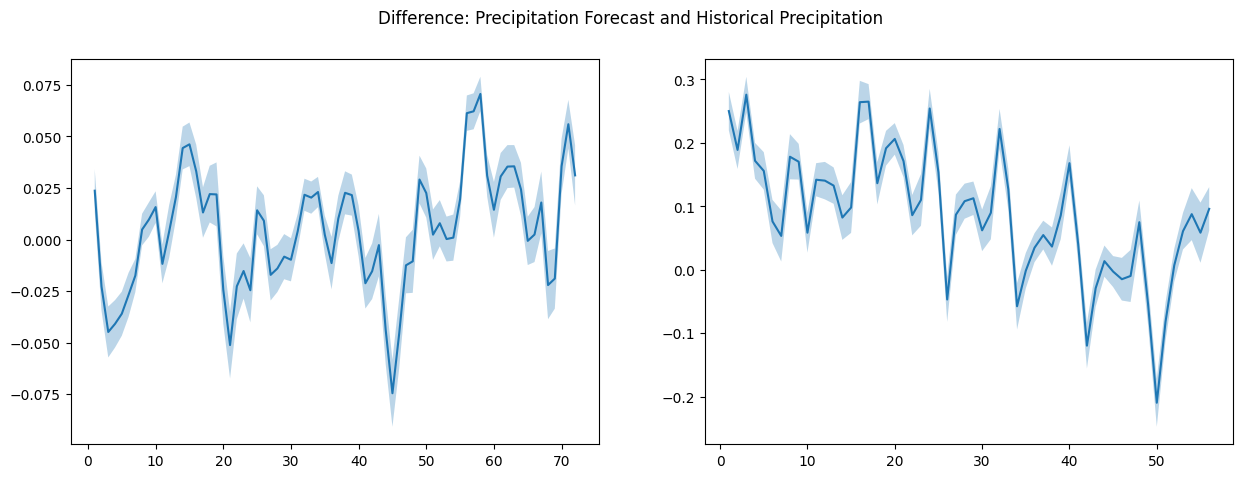

In [165]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

x_axis = np.arange(1, 73)
mean_1 = boot_strap_means_1.mean(axis=1)
std_1 = boot_strap_means_1.std(axis=1)

ax1.plot(x_axis, mean_1)
ax1.fill_between(x_axis, mean_1 - std_1, mean_1 + std_1, alpha=0.3)


x_axis = np.arange(1, 57)
mean_2 = boot_strap_means_2.mean(axis=1)
std_2 = boot_strap_means_2.std(axis=1)

ax2.plot(x_axis, mean_2)
ax2.fill_between(x_axis, mean_2 - std_2, mean_2 + std_2, alpha=0.3)

# TODO: ellipse plots???? 


look at the covariance between the estimated mean and the estimated standard variance. 

Correlation matrix between mean and standard variance for model 1
[[0.05917133 0.00142783]
 [0.00142783 0.01058336]]
Correlation matrix between mean and standard variance for model 2
[[1.00699688 0.15244315]
 [0.15244315 0.05798799]]


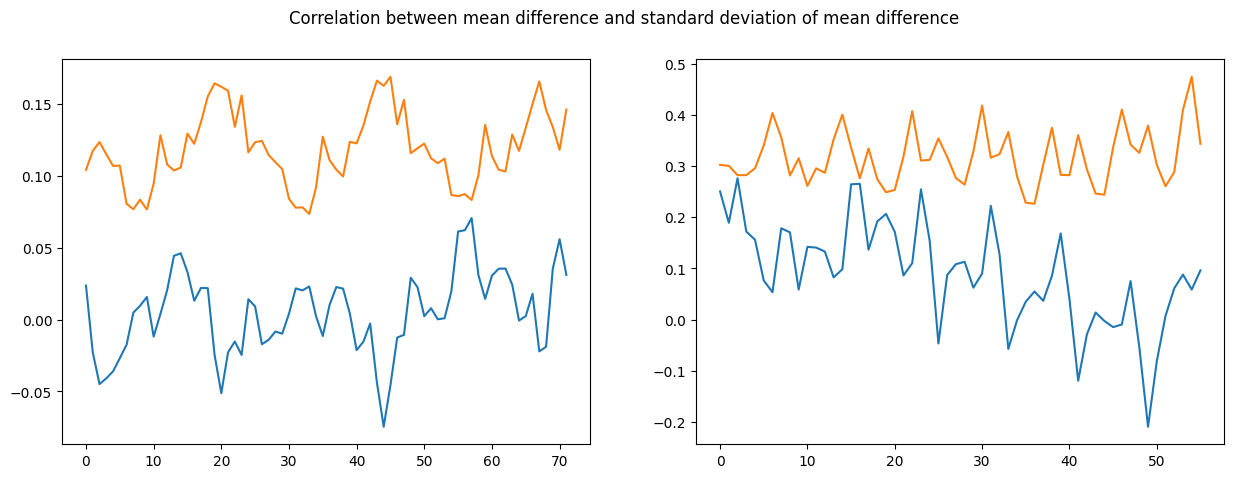

In [166]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Correlation between mean difference and standard deviation of mean difference")


ax1.plot(mean_1)
ax1.plot(std_1 * 10)

estimator_properties = np.stack([mean_1, std_1]).T
print("Correlation matrix between mean and standard variance for model 1")
print(estimator_properties.T @ estimator_properties)

ax2.plot(mean_2)
ax2.plot(std_2 * 10)

estimator_properties = np.stack([mean_2, std_2]).T
print("Correlation matrix between mean and standard variance for model 2")
print(estimator_properties.T @ estimator_properties)

Do a FFT on errors:

Do fft: 100%|██████████| 1/1 [00:00<00:00, 8848.74it/s]


Text(0.5, 0, 'Frequency in 1 / day ')

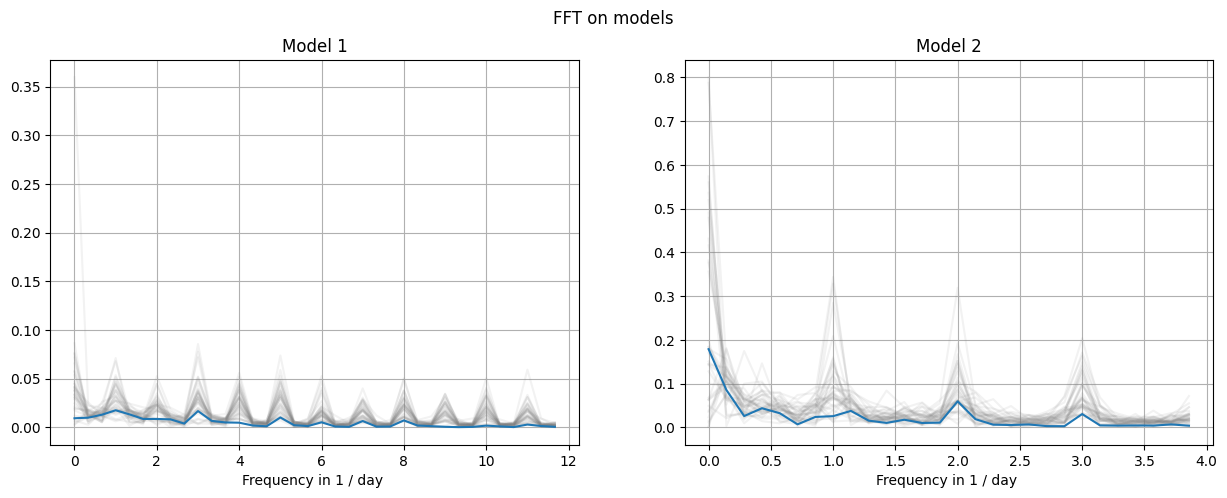

In [167]:
from typing import Tuple
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt


def do_fft(time_series: np.ndarray, period: float = 1) -> Tuple[np.ndarray, np.ndarray]:
    """perform fft on given time series

    Args:
        time_series (np.ndarray): shape (num_series, length of series)
        period (float, optional): _description_. Defaults to 1.

    Returns:
        Tuple[np.ndarray, np.ndarray]: _description_
    """
    # Number of sample points
    N = time_series.shape[-1]
    # sample spacing

    result = np.empty((time_series.shape[0], time_series.shape[1] // 2))
    for idx, station_error in enumerate(tqdm(time_series, desc="Do fft")):
        yf = fft(station_error)
        yf = 2.0 / N * np.abs(yf[0 : N // 2])
        result[idx] = yf

    xf = fftfreq(N, period)[: N // 2]
    return xf, result


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("FFT on models")

# station_errors_model_1 = np.concatenate(error_mat_model_1, axis=0)
station_errors_model_1 = error_mat_model_1.mean(axis=0)
T = 3600
xf, yf = do_fft(station_errors_model_1, T)
xf *= T * 24
ax1.plot(xf, yf.T, color="grey", alpha=0.1)
ax1.plot(xf, do_fft(station_errors_model_1.mean(axis=0)[None], T)[1].T)


station_errors_model_2 = error_mat_model_2.mean(axis=0)
T = 3600 * 3
xf, yf = do_fft(station_errors_model_2, T)
xf *= T * 8
ax2.plot(xf, yf.T, color="grey", alpha=0.1)
ax2.plot(xf, do_fft(station_errors_model_2.mean(axis=0)[None], T)[1].T)

# convert xf 
# xf *= 3600 * 24
# ax2.plot(xf, yf.T, c="grey", alpha=0.01)
# ax2.plot(xf, yf.mean(axis=0))
# ax2.plot(xf, yf.mean(axis=0))

ax1.grid()
ax1.set_title("Model 1")
ax1.set_xlabel("Frequency in 1 / day ")
ax2.grid()
ax2.set_title("Model 2")
ax2.set_xlabel("Frequency in 1 / day ")


Is one call time prone to errors

(35,) [0.6625     0.5109623  0.25615079 0.19429563 0.25575397 0.50947421
 0.59315476 0.69022817 0.80947421 1.28556548 1.03710317 0.72614087
 0.47395833 0.28571429 0.35793651 0.22996032 0.45372024 0.68358135
 0.75972222 0.68179563 0.64032738 0.68482143 0.59404762 0.43318452
 0.2140873  0.23547454 0.26465278 0.11883681 0.03958333 0.02986111
 0.03715278        nan]
[[1.44185961 1.93228365]
 [1.93228365 9.67862777]]


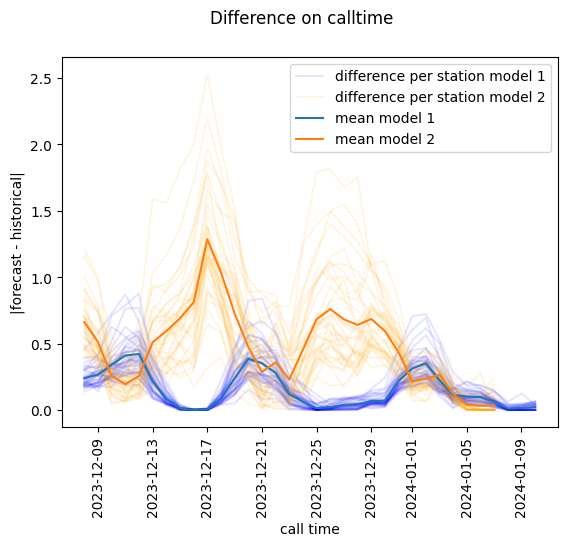

In [168]:
merge1 = dataset_model_1.get_merge()
merge1["precipitation_error"] = merge1["precipitation_error"].abs()
merge2 = dataset_model_2.get_merge()
merge2["precipitation_error"] = merge2["precipitation_error"].abs()


fig, ax1 = plt.subplots()
fig.suptitle("Difference on calltime")


individual_groups = merge1.groupby(["station_id", "call_time"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("station_id").unique()):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(sub_df.index, sub_df["precipitation_error"], c="blue", alpha=0.1, label="difference per station model 1" if not idx else "")

individual_groups = merge2.groupby(["station_id", "call_time"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("station_id").unique()):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(sub_df.index, sub_df["precipitation_error"], c="orange", alpha=0.1, label="difference per station model 2" if not idx else "")

# add mean values

call_time_groups_1 = merge1.groupby(["call_time"]).mean()
t = call_time_groups_1.index.values
# t = t - min(t)
# t = t / (3600 * 24 * 1e9) 
ax1.plot(t, call_time_groups_1["precipitation_error"], label="mean model 1")

call_time_groups_2 = merge2.groupby(["call_time"]).mean()
t = call_time_groups_2.index.values
# t = t - min(t)
# t = t / (3600 * 24 * 1e9) 
ax1.plot(t, call_time_groups_2["precipitation_error"], label="mean model 2")

# add rain


ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel("call time")
ax1.set_ylabel("|forecast - historical|")
ax1.legend()

# compute correlation 
print(call_time_groups_1["precipitation_error"].values.shape, call_time_groups_2["precipitation_error"].values[:len(call_time_groups_1)])
x = np.stack([call_time_groups_1["precipitation_error"].values[:len(call_time_groups_2)-1], call_time_groups_2["precipitation_error"].values[:len(call_time_groups_1)][:-1]])
print(x @ x.T)

which time between 0 and 24 is prone to errors 


                call_time  station_id                time  \
0     2023-12-11 00:10:01         757 2023-12-13 23:00:00   
1     2023-12-11 00:10:01         757 2023-12-14 02:00:00   
2     2023-12-11 00:10:01         757 2023-12-14 05:00:00   
3     2023-12-11 00:10:01         757 2023-12-14 08:00:00   
4     2023-12-11 00:10:01         757 2023-12-14 11:00:00   
...                   ...         ...                 ...   
56695 2023-12-26 00:10:01        2575 2024-01-04 08:00:00   
56696 2023-12-26 00:10:01        2575 2024-01-04 11:00:00   
56697 2023-12-26 00:10:01        2575 2024-01-04 14:00:00   
56698 2023-12-26 00:10:01        2575 2024-01-04 17:00:00   
56699 2023-12-26 00:10:01        2575 2024-01-04 20:00:00   

       precipitation_forecast  air_temperature_forecast  precipitation_real  \
0                         0.3                       NaN                 5.3   
1                         0.4                       NaN                 1.3   
2                         0.3 

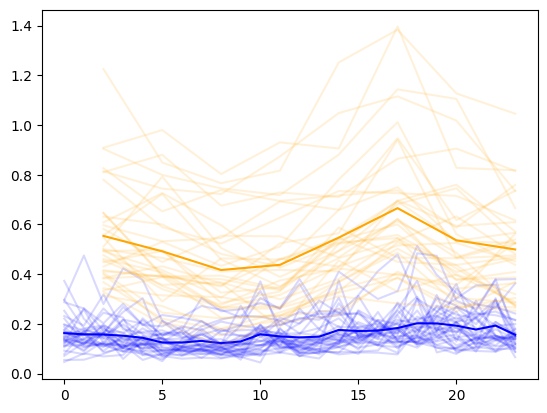

In [169]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()

fig, ax1 = plt.subplots()

# insert hour column 
merge1.insert(len(merge1.columns), "hour", merge1["time"].dt.hour, allow_duplicates=True)

individual_groups = merge1.groupby(["station_id", "hour"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("station_id").unique()):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(sub_df.index, sub_df["precipitation_error"], c="blue", alpha=0.15, label="difference per station model 2" if not idx else "")

time_group = merge1.groupby(["hour"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"].values, c="b")

# insert hour column 
merge2.insert(len(merge2.columns), "hour", merge2["time"].dt.hour, allow_duplicates=True)
print(merge2)
individual_groups = merge2.groupby(["station_id", "hour"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("station_id").unique()):
    sub_df = individual_groups.xs(station_id, level="station_id")
    ax1.plot(sub_df.index, sub_df["precipitation_error"], c="orange", alpha=0.15, label="difference per station model 2" if not idx else "")

time_group = merge2.groupby(["hour"]).mean()
ax1.plot(time_group.index, time_group["precipitation_error"].values, c="orange")

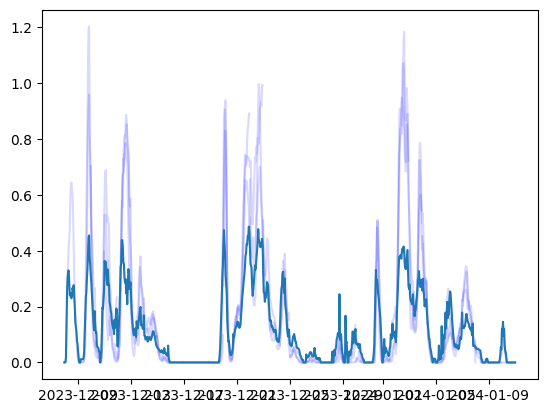

In [175]:
merge1 = dataset_model_1.get_merge().copy()
merge2 = dataset_model_2.get_merge().copy()


fig, ax1 = plt.subplots()

individual_groups = merge1.groupby(["call_time", "time"]).mean()
for idx, station_id in enumerate(individual_groups.index.get_level_values("call_time").unique()):
    sub_df = individual_groups.xs(station_id, level="call_time")
    ax1.plot(sub_df.index, sub_df["precipitation_forecast"], c="blue", alpha=0.15, label="difference per station model 2" if not idx else "")


time_group = merge1.groupby("time").std()

ax1.plot(time_group.index, time_group["precipitation_forecast"])

relative error to amount of rain $ (forecast - historical) / historical$


Compute correlation between error and time to forecast?
Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


given the amount of predicted precipitation whats the expected error 

In [171]:
merge1 = dataset_model_1.get_merge

Compute on average divergence for a forecast into the future. 
Observer how a forecast changes over time

relative error to amount of rain $ (forecast - historical) / historical$

